## More text classification tasks, BERT fine-tuning, and model analysis

This notebook contains a couple more examples of text classification tasks, in addition to those shown in the lesson notebooks, that involve fine-tuning a pre-trained BERT model. They each involve some sort of binary or categorical labels, not text generation as the output. But the problem structure is slightly different for each task.

We'll try fine-tuning a couple different BERT models for each task, so that we can also include some of the basic types of analysis we'd expect to see in your projects. We not only want to look at a common overall evaluation metric to see which model works better, but try to understand the differences in the models' predictions to figure out why.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2024-fall-main/blob/master/materials/model_analysis/more_bert_tasks_and_model_analysis.ipynb)

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import re
import json
import numpy as np
import pandas as pd

import torch
import evaluate
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Mount drive for saving model checkpoints, and for loading Task 2 data below

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Task 1: GLUE MRPC (Microsoft Research Paraphrase Corpus)

This dataset has pairs of sentences with labels indicating whether the two sentences are equivalent (i.e. they mean the same thing) or not. [Dataset on Huggingface](https://huggingface.co/datasets/nyu-mll/glue), [paper here](https://openreview.net/pdf?id=rJ4km2R5t7).

In [ ]:
mrpc_data = load_dataset('nyu-mll/glue', 'mrpc')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [ ]:
# The data comes pre-split, includes pairs of sentences with a label for each
mrpc_data

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [ ]:
# Here are the labels
mrpc_data['train'].features['label'].names

['not_equivalent', 'equivalent']

In [ ]:
# Look at the first few examples in the data
for i in range(4):
  print(mrpc_data['train']['sentence1'][i])
  print(mrpc_data['train']['sentence2'][i])
  print(mrpc_data['train']['label'][i])
  print()

Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
1

Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .
Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .
0

They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .
On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .
1

Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .
Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .
0



#### Models

For both tasks, we'll use a BERT-style model called [DistilRoBERTa](https://huggingface.co/distilroberta-base). It's a based on RoBERTa, a popular variant of BERT with a slightly different pre-training task and other tweaks. And the "Distil" part means it's smaller model than BERT base, with only six transformer blocks instead of 12.

When we want to test a particular hypothesis (e.g. does fine-tuning on a related dataset help with our main task), it's useful to hold other factors constant (e.g. the model architecture and size) so that we know what the main difference is that is driving any difference in performance we observe. It could also be useful to compare different architectures or model sizes, but we'd want to make an isolated comparison for each of those factors. In this notebook, we'll stick with DistilRoBERTa models, and compare versions that have been fine-tuned on different datasets that might be related to our main tasks.

We'll use the DistilRoBERTa base model as one of the models for each task. For the MRPC paraphrase task, we'll compare the base model to a version that's been fine-tuned on a natural language inference (NLI) dataset. NLI is conceptually similar to the paraphrase task we're focused on, since it involves pairs of sentences labeled with whether the first sentence entails the second (i.e. whether they have factually consistent information).

Using a model that has already been trained on a similar task might help the model learn our task more effectively, even with a fairly small dataset for our main task. You can [search/browse available models on Huggingface here](https://huggingface.co/models).

In [ ]:
mrpc_bert_model_names = ['distilroberta-base',
                         'sentence-transformers/nli-distilroberta-base-v2']
mrpc_tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
                   for bert_model_name in mrpc_bert_model_names]
mrpc_bert_models = [AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=2)
                    for bert_model_name in mrpc_bert_model_names]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

We'll need a function to preprocess our data into vocab_ids, using the relevant BERT tokenizer for each model.

In [ ]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

max_length = 128

def preprocess_mrpc(data, tokenizer):
    sents1 = data['sentence1']
    sents2 = data['sentence2']

    sentence_pairs = [(sents1[i], sents2[i]) for i in range(len(sents1))]
    encoded = tokenizer.batch_encode_plus(
            sentence_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt"
        )

    return encoded

We'll use Huggingface's TrainingArguments and Trainer classes to do the fine-tuning. The TrainingArguments class takes an output directory path to save a model checkpoint after each epoch. Set the path to somewhere in your Drive, so that the checkpoint persists after the notebook goes away, so you can load the fine-tuned models again later as needed.


In [ ]:
# Edit this filepath to a place in your own Drive where you want to save the model checkpoints.

checkpoint_filepath = 'drive/MyDrive/ISchool/MIDS/266/model_checkpoints/mrpc/'

In [ ]:
# Create a TrainingArguments object, specifying batch size and num epochs.

batch_size = 16
num_epochs = 2

training_args = TrainingArguments(
    output_dir=checkpoint_filepath,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    save_strategy="epoch"
)

In [20]:
# Define a compute_metrics function to monitor during training

metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Both tasks have somewhat imbalanced data, so it's a good idea to apply class weights. We can make a custom Trainer class and just modify the compute_loss to use class weights.

In [21]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
          super().__init__(*args, **kwargs)
          self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        # forward pass
        outputs = model(**inputs)
        logits = outputs['logits']
        # compute custom loss
        class_weights = torch.Tensor(self.class_weights)
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.cuda())
        loss = loss_fn(logits, inputs['labels'])
        return (loss, outputs) if return_outputs else loss

We have two models for this task, both of which are small models, along with a small dataset. We'll want to do the same training and evaluation steps on both models, then compare them. Since these models won't take long to train, let's make a loop to preprocess the dataset with each tokenizer, use that data to fine-tune the corresponding model, and save a model checkpoint, so we can do our evaluation and analysis afterwards.

In [ ]:
# Now train each model, and store the trained models in a dict for later analysis


mrpc_class_weights = softmax(class_weight.compute_class_weight(
    'balanced', classes=np.arange(2),  y=mrpc_data['train']['label']))

for i in range(len(mrpc_bert_model_names)):

    mrpc_train_dataset = mrpc_data['train'].map(preprocess_mrpc, batched=True, fn_kwargs={'tokenizer': mrpc_tokenizers[i]})
    mrpc_validation_dataset = mrpc_data['validation'].map(preprocess_mrpc, batched=True, fn_kwargs={'tokenizer': mrpc_tokenizers[i]})

    trainer = CustomTrainer(
        mrpc_class_weights,
        model=mrpc_bert_models[i],
        args=training_args,
        train_dataset=mrpc_train_dataset,
        eval_dataset=mrpc_validation_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

{'eval_loss': 0.3739832639694214, 'eval_accuracy': 0.8480392156862745, 'eval_runtime': 1.4925, 'eval_samples_per_second': 273.363, 'eval_steps_per_second': 17.42, 'epoch': 1.0}
{'eval_loss': 0.41866782307624817, 'eval_accuracy': 0.8676470588235294, 'eval_runtime': 1.5602, 'eval_samples_per_second': 261.512, 'eval_steps_per_second': 16.665, 'epoch': 2.0}
{'train_runtime': 113.3529, 'train_samples_per_second': 64.718, 'train_steps_per_second': 4.058, 'train_loss': 0.4322509765625, 'epoch': 2.0}


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

{'eval_loss': 0.3468989133834839, 'eval_accuracy': 0.8357843137254902, 'eval_runtime': 1.4903, 'eval_samples_per_second': 273.766, 'eval_steps_per_second': 17.446, 'epoch': 1.0}
{'eval_loss': 0.41598743200302124, 'eval_accuracy': 0.8700980392156863, 'eval_runtime': 1.5441, 'eval_samples_per_second': 264.233, 'eval_steps_per_second': 16.838, 'epoch': 2.0}
{'train_runtime': 113.7323, 'train_samples_per_second': 64.502, 'train_steps_per_second': 4.045, 'train_loss': 0.4336535578188689, 'epoch': 2.0}


The second model (distilroberta-nli) got the highest overall validation accuracy. That said, when the scores are close, it can be difficult to understand which model did better, how much and in what ways, just by looking at a single overall metric.

We'll dig into more metrics in the analysis section below. But first let's go through the second task, then we can do the same analysis on both.

### Task 2. Github Bugs Prediction Challenge (Machine Hack)

This dataset contains the titles and bodies of Github discussion posts, labeled with whether the post is about a bug, feature, or question. According to the documentation page, the labels are:
- Bug - 0
- Feature - 1
- Question - 2

The [data is available here](https://www.kaggle.com/datasets/arbazkhan971/github-bugs-prediction-challenge-machine-hack?resource=download). Download the data, upload to Google Drive, and mount your Drive to load the data.

We'll use the train data file for both training and validation, since the provided test data doesn't have labels (which we need for evaluation). Let's first split the provided train data into our own train/dev split and save as separate files, so that we keep using the same split even if we reload the notebook. Then we can create a Hugginface dataset object from each of those files.

In [4]:
github_filepath = 'drive/MyDrive/ISchool/MIDS/266/data/embold_train.json'

with open(github_filepath, 'r') as f:
    github_data = json.load(f)

df_github = pd.DataFrame(github_data)
df_github.shape

(150000, 3)

In [5]:
df_github['label'].unique()

array([1, 0, 2])

In [6]:
# Since this is an example notebook, we'll just use 40k training examples and
# 1k validation (always shuffling first). You can explore using more on your own.

df_github = df_github.sample(frac=1)
df_github_train = df_github[0:40000]
df_github_dev = df_github[40000:41000]

In [8]:
# Edit these filepaths to wherever you saved the data in your Drive
github_train_filepath = 'drive/MyDrive/ISchool/MIDS/266/data/embold_github_train.csv'
github_dev_filepath = 'drive/MyDrive/ISchool/MIDS/266/data/embold_github_dev.csv'

df_github_train.to_csv(github_train_filepath, index=False)
df_github_dev.to_csv(github_dev_filepath, index=False)

In [12]:
# Load the splits as Huggingface datasets
github_train_dataset = load_dataset("csv", data_files=github_train_filepath)['train']
github_dev_dataset = load_dataset("csv", data_files=github_dev_filepath)['train']

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
# Look at what's in the dataset
github_train_dataset

Dataset({
    features: ['title', 'body', 'label'],
    num_rows: 40000
})

In [14]:
# Look at the first few examples in the data
for i in range(4):
    print(github_train_dataset['title'][i])
    print(github_train_dataset['body'][i])
    print(github_train_dataset['label'][i])
    print()

launch image missing sizes
i can't get any of the launch image sizes generated to be compatible with the latest version of xcode 9.3.1. i have not been able to match up a single launch image. i have an exclamation badge on every launch image that indicates the size is not as desired. can this be fixed?
0

syntax error, skip '__namespace'
thanks for such a wonderful plugin.  eventhough the analysis is successful, i'm not sure what to make of these warnings.   \r \r these warnings are printed on the sonar-scanner stdout \r \r   warn:  /home/jenkins/workspace/sonar/lis/src/core/ccparse/lib/factory.c:39 : syntax error, skip '__namespace'  \r \r whenever sonar comes across code that looks like this? everything within the namespace block is posted as a syntax error on stdout.  \r \r  include <ccparse/factory.h>\r namespace ccparse {
2

invalid gene symbol does not give warning
in queries, after some gene symbol entries, application does not give invalid gene symbol warning.\r \r - try to ent

#### Models

For the Github task, we'll also start with distilroberta-base as our first model. For comparison, we'll use a model that has been fine-tuned on a SQuAD question answering dataset.

The SQuAD task doesn't seem quite as related to our Github issues classification task, as the NLI task was to the MRPC paraphrase task. I looked for a DistilRoBERTa model that had already been fine-tuned on something like a customer complaints dataset, thinking that might have some similar concepts to Githug bug and issue reports. But DistilRoBERTa isn't quite as commonly used as the larger BERT models, so there weren't as many options in Huggingface. Still, question-answering is somewhat related, since the Github issues often involve questions that users are asking to be solved. We'll see how well it works for our main task.

As with the MRPC task, we're using the AutoModelForSequenceClassification model class. The AutoModel classes infer which type of model (BERT, etc) to load based on the model checkpoint name. The ForSequenceClassification part means that Huggingface will use the pre-trained BERT model up until its last hidden layer, and add a new dense classification layer at the end for our task (passing the BERT CLS pooler output into the classification layer). Since the github task has three classes, we need to specify the size the output layer we want when loading the model (using num_labels=3).

In [15]:
github_bert_model_names = ['distilroberta-base',
                           'squirro/distilroberta-base-squad_v2']
github_tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
                   for bert_model_name in github_bert_model_names]
github_bert_models = [AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=3)
                    for bert_model_name in github_bert_model_names]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/326M [00:00<?, ?B/s]

Create a preprocessing function for the task, similar to MRPC, which takes the relevant tokenizer for the model to be used.

In [16]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

def preprocess_github(data, tokenizer):
    titles = data['title']
    bodies = data['body']

    text_pairs = [(titles[i], bodies[i]) for i in range(len(titles))]
    encoded = tokenizer.batch_encode_plus(
            text_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt"
        )

    return encoded

Same as with the MRPC task, for the Github task we'll make one TrainingArguments object, and specify a filepath to save the model checkpoints. Then we'll make a loop to preprocess the dataset with each tokenizer, use that data to fine-tune the corresponding model, and save a model so we can do our evaluation and analysis afterwards.

In [17]:
# Edit this filepath to a place in your own Drive where you want to save the fine-tuned github models.

checkpoint_filepath = 'drive/MyDrive/ISchool/MIDS/266/model_checkpoints/github/'

In [18]:
batch_size = 16
num_epochs = 2

training_args = TrainingArguments(
    output_dir=checkpoint_filepath,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    save_strategy="epoch"
)

In [ ]:
# Now train each model, and store the trained models in a dict for later analysis

max_length = 128

github_class_weights = softmax(class_weight.compute_class_weight(
    'balanced', classes=np.arange(3), y=github_train_dataset['label']))

for i in range(len(github_bert_model_names)):

    github_train_dataset_ready = github_train_dataset.map(preprocess_github, batched=True, fn_kwargs={'tokenizer': github_tokenizers[i]})
    github_dev_dataset_ready = github_dev_dataset.map(preprocess_github, batched=True, fn_kwargs={'tokenizer': github_tokenizers[i]})

    trainer = CustomTrainer(
        github_class_weights,
        model=github_bert_models[i],
        args=training_args,
        train_dataset=github_train_dataset_ready,
        eval_dataset=github_dev_dataset_ready,
        compute_metrics=compute_metrics,
    )

    trainer.train()

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'loss': 0.8131, 'grad_norm': 6.716183662414551, 'learning_rate': 4.5e-05, 'epoch': 0.2}
{'loss': 0.6815, 'grad_norm': 11.638193130493164, 'learning_rate': 4e-05, 'epoch': 0.4}
{'loss': 0.6715, 'grad_norm': 8.65990924835205, 'learning_rate': 3.5e-05, 'epoch': 0.6}
{'loss': 0.6536, 'grad_norm': 7.1934075355529785, 'learning_rate': 3e-05, 'epoch': 0.8}
{'loss': 0.6345, 'grad_norm': 17.045312881469727, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'eval_loss': 0.6656531691551208, 'eval_accuracy': 0.706, 'eval_runtime': 3.6768, 'eval_samples_per_second': 271.973, 'eval_steps_per_second': 17.134, 'epoch': 1.0}
{'loss': 0.5738, 'grad_norm': 2.58147931098938, 'learning_rate': 2e-05, 'epoch': 1.2}
{'loss': 0.5426, 'grad_norm': 67.5640640258789, 'learning_rate': 1.5e-05, 'epoch': 1.4}
{'loss': 0.5636, 'grad_norm': 3.1595895290374756, 'learning_rate': 1e-05, 'epoch': 1.6}
{'loss': 0.5367, 'grad_norm': 9.24709701538086, 'learning_rate': 5e-06, 'epoch': 1.8}
{'loss': 0.5556, 'grad_norm': 1.302274227142

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'loss': 0.8233, 'grad_norm': 10.23844051361084, 'learning_rate': 4.5e-05, 'epoch': 0.2}
{'loss': 0.6939, 'grad_norm': 9.03752613067627, 'learning_rate': 4e-05, 'epoch': 0.4}
{'loss': 0.6815, 'grad_norm': 9.56615924835205, 'learning_rate': 3.5e-05, 'epoch': 0.6}
{'loss': 0.6716, 'grad_norm': 5.495742321014404, 'learning_rate': 3e-05, 'epoch': 0.8}
{'loss': 0.629, 'grad_norm': 30.53375244140625, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'eval_loss': 0.6255969405174255, 'eval_accuracy': 0.749, 'eval_runtime': 3.8031, 'eval_samples_per_second': 262.944, 'eval_steps_per_second': 16.565, 'epoch': 1.0}
{'loss': 0.5814, 'grad_norm': 1.2200846672058105, 'learning_rate': 2e-05, 'epoch': 1.2}
{'loss': 0.5568, 'grad_norm': 13.740076065063477, 'learning_rate': 1.5e-05, 'epoch': 1.4}
{'loss': 0.5763, 'grad_norm': 4.443273067474365, 'learning_rate': 1e-05, 'epoch': 1.6}
{'loss': 0.5394, 'grad_norm': 28.176481246948242, 'learning_rate': 5e-06, 'epoch': 1.8}
{'loss': 0.5635, 'grad_norm': 0.777392029762

In this task, it also look slike the second model (the SQuAD fine-tuned model) did a little better than the first (distilroberta-base). But again, the validation accuracy numbers are close, so we should dive in further to try to understand more about when and/or why one model works better than another for this task.

### Breaking Down Evaluation Metrics

Does the validation accuracy shown above give us enough info to simply pick a winning model? Is there more that we can try to understand about which model works better under what conditions, or what types of errors each one is making, so that we can learn how to use them and try to further improve them?

For instance, is one model missing more bugs or features than the other (in the Github data)? Is one over- or under-predicting paraphrase equivalence (in the MRPC data)? A good place to start is to look at precision and recall by label class, as well as a confusion matrix. We'll use the validation data for each task to do so.

In [24]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm/cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

distilroberta-base
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       129
           1       0.91      0.90      0.90       279

    accuracy                           0.87       408
   macro avg       0.85      0.85      0.85       408
weighted avg       0.87      0.87      0.87       408

sentence-transformers/nli-distilroberta-base-v2
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       129
           1       0.93      0.88      0.90       279

    accuracy                           0.87       408
   macro avg       0.85      0.87      0.85       408
weighted avg       0.88      0.87      0.87       408



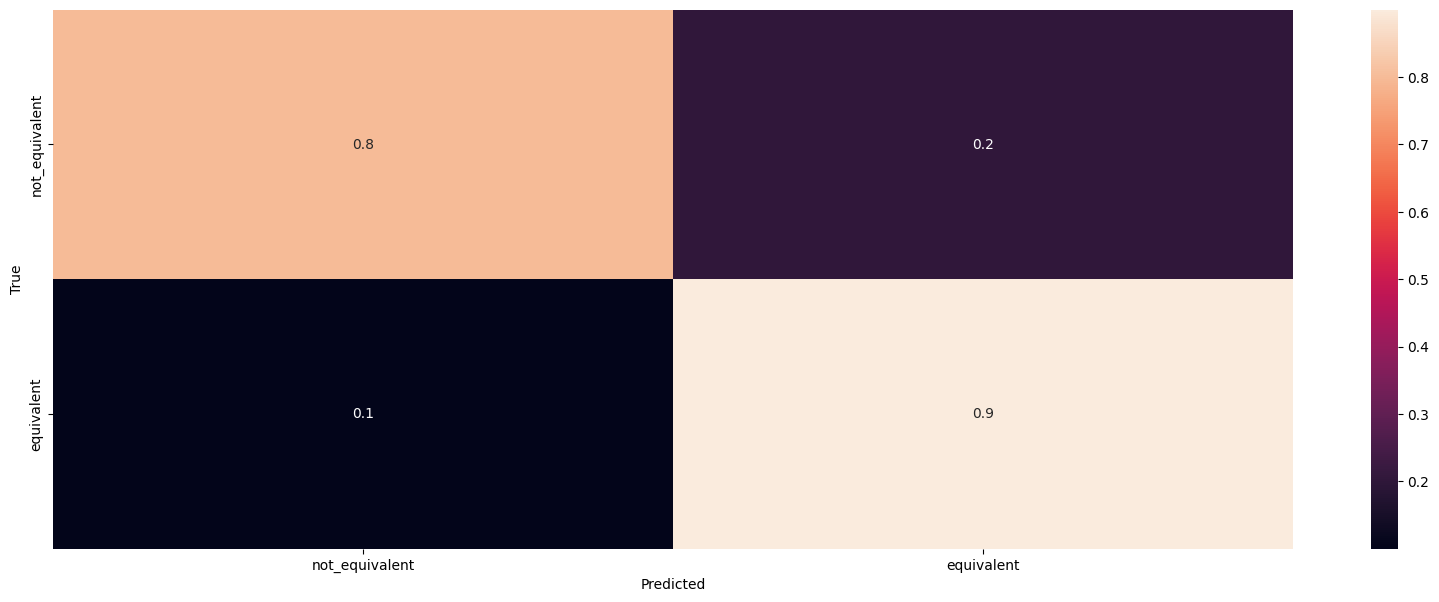

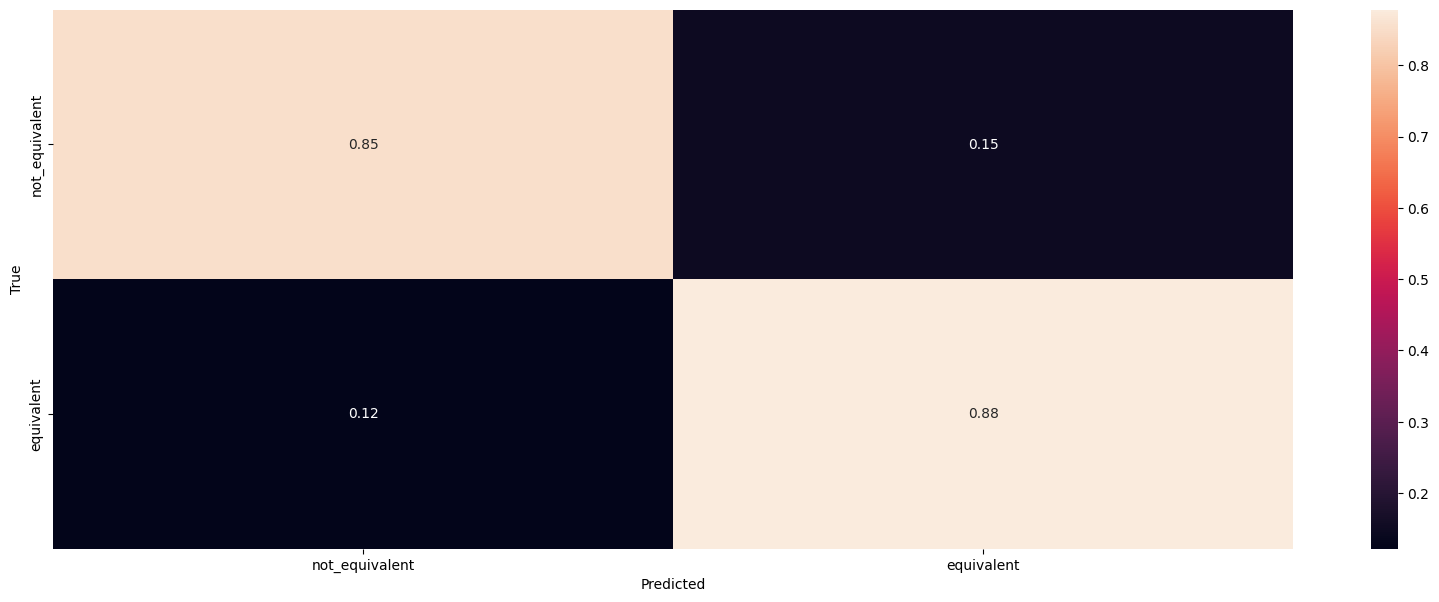

In [ ]:
# Print classification report and confusion matrix for each model, for MRPC task.

mrpc_label_names = mrpc_data['train'].features['label'].names

mrpc_wrong_guesses = {}  # Save indices of wrong guesses so we can look at them later

batch_size = 16
num_batches = int((len(mrpc_data['validation']['label']) + batch_size - 1) / batch_size)

for i in range(len(mrpc_bert_model_names)):
    print(mrpc_bert_model_names[i])

    mrpc_validation_labels = mrpc_data['validation']['label']
    mrpc_y_preds = []

    for batch in range(num_batches):
        mrpc_validation_inputs = preprocess_mrpc(mrpc_data['validation'][batch*batch_size:(batch+1)*batch_size], mrpc_tokenizers[i])
        mrpc_y_logits = mrpc_bert_models[i].cpu()(**mrpc_validation_inputs).logits.detach().numpy()
        mrpc_y_preds.append(np.argmax(mrpc_y_logits, axis=1))

    mrpc_y_pred = np.concatenate(mrpc_y_preds, axis=0)
    print(classification_report(mrpc_validation_labels, mrpc_y_pred))

    plot_confusion_matrix(mrpc_validation_labels, mrpc_y_pred, mrpc_label_names)

    mrpc_wrong_guesses[mrpc_bert_model_names[i]] = np.where(mrpc_validation_labels != mrpc_y_pred)

For the MRPC task, the second model (distilroberta-nli) does appear to perform better than the first model (distilroberta-base). In particular, it seems to have handled the imbalanced data a little better.

The first model slightly overpredicts the majority class, while the second model is more balanced. The largest difference in category-level metrics is how much the second model increased recall of the minority class over the first model.

This seems to support our hypothesis that the second model's prior training on an NLI dataset helped it do well on our MRPC paraphrase task. It's not perfect, though. So we should still take a look at some examples that the model is still getting wrong (below).

But first, let's print the same breakdown of evaluation metrics and confusion matrix for the second task, the Github issues.

distilroberta-base
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       430
           1       0.89      0.79      0.84       491
           2       0.37      0.67      0.48        79

    accuracy                           0.79      1000
   macro avg       0.69      0.75      0.71      1000
weighted avg       0.82      0.79      0.80      1000

squirro/distilroberta-base-squad_v2
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       430
           1       0.90      0.79      0.84       491
           2       0.40      0.72      0.52        79

    accuracy                           0.81      1000
   macro avg       0.72      0.78      0.73      1000
weighted avg       0.84      0.81      0.82      1000



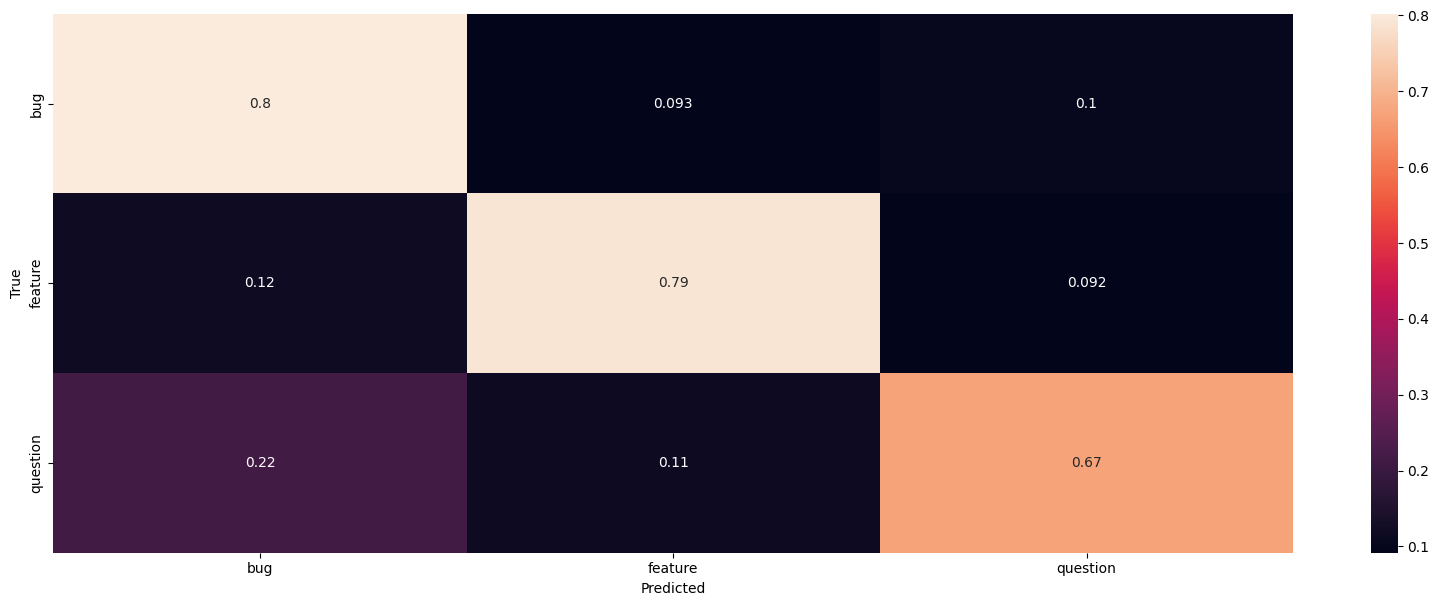

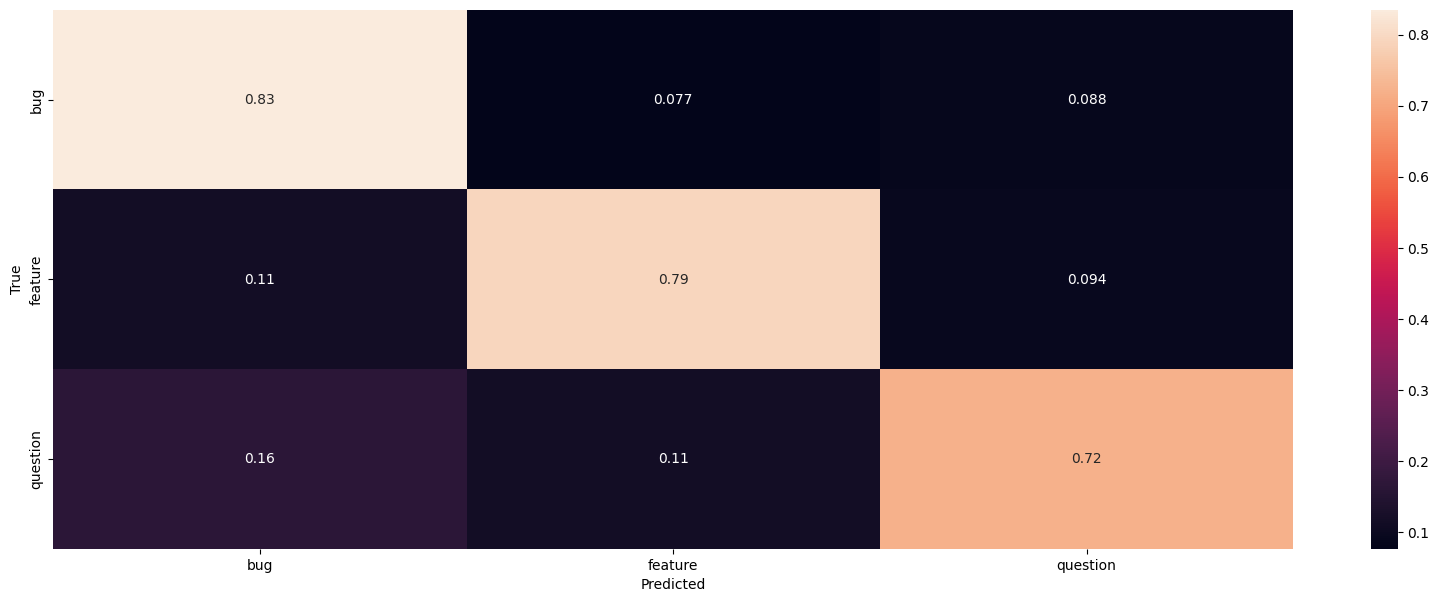

In [ ]:
# Print classification report and confusion matrix for each model, for Github issues task.

github_label_names = ['bug', 'feature', 'question']

github_wrong_guesses = {}

batch_size = 16
num_batches = int((len(github_dev_dataset['label']) + batch_size - 1) / batch_size)

for i in range(len(github_bert_model_names)):
    print(github_bert_model_names[i])

    github_validation_labels = github_dev_dataset['label']
    github_y_preds = []

    for batch in range(num_batches):
        github_validation_inputs = preprocess_github(github_dev_dataset[batch*batch_size:(batch+1)*batch_size], github_tokenizers[i])
        github_y_logits = github_bert_models[i].cpu()(**github_validation_inputs).logits.detach().numpy()
        github_y_preds.append(np.argmax(github_y_logits, axis=1))

    github_y_pred = np.concatenate(github_y_preds, axis=0)
    print(classification_report(github_validation_labels, github_y_pred))

    plot_confusion_matrix(github_validation_labels, github_y_pred, github_label_names)

    github_wrong_guesses[github_bert_model_names[i]] = np.where(github_validation_labels != github_y_pred)

The story is similar here. The second model (the SQuAD trained one) seems to perform better than the first model (distilroberta-base) across all categories, but especially the smallest category (questions). That is by far the smallest category, and both models struggled with it. But the first model underpredicted questions more than the second model.

Hey, that kind of makes sense, right? The questions category is so small, that the general-purpose base model has not learned to identify it very well. But the second model, which was specifically trained to understand questions (via the SQuAD dataset), seems better able to recognize what a question is, even when our dataset for this task has very few of them.

This might also be a realization we could have made after we trained and evaluated the first model. Even if we didn't think to use a model fine-tuned on question answering at first, we might think of it after looking at the first model's results. Since the first model is weakest on that third category of questions, and we might not have a way to augment the data to add more Github-style question examples, we might consider trying fine-tuning our model another dataset more focused on question style text in order to help it better recognize questions in the Github dataset.

Let's see if there's anything else we can learn about this model comparison, or further evidence we can use to validate what we think is happening, when we look at the remaining misclassifications directly.

### Inspecting Misclassifications

It's always important to look at actual examples from our validation data, to see what mistakes the model is making. Below, we'll use the indices of the examples each model got wrong. We'll separate them into examples that only one model got wrong but not the other, as well as examples both models got wrong, and print out a sample from each to look at.

In [ ]:
# MRPC: examples that the first model got right and the second got wrong

mrpc_examples_model1_better = [i for i in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[1]])
                               if i not in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[0]])]

for i in mrpc_examples_model1_better[:10]:
    print(mrpc_data['validation']['sentence1'][i])
    print(mrpc_data['validation']['sentence2'][i])
    print(mrpc_data['validation']['label'][i])

" Sanitation is poor ... there could be typhoid and cholera , " he said .
" Sanitation is poor , drinking water is generally left behind . . . there could be typhoid and cholera . "
0
Unable to find a home for him , a judge told mental health authorities they needed to find supervised housing and treatment for DeVries somewhere in California .
The judge had told the state Department of Mental Health to find supervised housing and treatment for DeVries somewhere in California .
1
At community colleges , tuition will jump to $ 2,800 from $ 2,500 .
Community college students will see their tuition rise by $ 300 to $ 2,800 or 12 percent .
1
Robert Liscouski , the Assistant Secretary of Homeland Security for Infrastructure Protection , will oversee NCSD .
NCSD 's chief will be Robert Liscouski , the assistant secretary of Homeland Security for Infrastructure Protection .
1
" I don 't know if the person I 'm talking to now may end up being someone else at another time that may not follow the

In [ ]:
# MRPC: examples that the second model got right and the first got wrong

mrpc_examples_model2_better = [i for i in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[0]])
                               if i not in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[1]])]

for i in mrpc_examples_model2_better[:10]:
    print(mrpc_data['validation']['sentence1'][i])
    print(mrpc_data['validation']['sentence2'][i])
    print(mrpc_data['validation']['label'][i])

Cooley said he expects Muhammad will similarly be called as a witness at a pretrial hearing for Malvo .
Lee Boyd Malvo will be called as a witness Wednesday in a pretrial hearing for fellow sniper suspect John Allen Muhammad .
0
Bush wanted " to see an aircraft landing the same way that the pilots saw an aircraft landing , " White House press secretary Ari Fleischer said yesterday .
On Tuesday , before Byrd 's speech , Fleischer said Bush wanted ' ' to see an aircraft landing the same way that the pilots saw an aircraft landing .
0
Myanmar 's pro-democracy leader Aung San Suu Kyi will return home late Friday but will remain in detention after recovering from surgery at a Yangon hospital , her personal physician said .
Myanmar 's pro-democracy leader Aung San Suu Kyi will be kept under house arrest following her release from a hospital where she underwent surgery , her personal physician said Friday .
1
GE stock closed at $ 30.65 a share , down about 42 cents , on the New York Stock Exc

In [ ]:
# MRPC: examples that both models got wrong

mrpc_examples_both_wrong = np.intersect1d(mrpc_wrong_guesses[mrpc_bert_model_names[0]],
                                          mrpc_wrong_guesses[mrpc_bert_model_names[1]])

for i in mrpc_examples_both_wrong[:10]:
    print(mrpc_data['validation']['sentence1'][i])
    print(mrpc_data['validation']['sentence2'][i])
    print(mrpc_data['validation']['label'][i])

While dioxin levels in the environment were up last year , they have dropped by 75 percent since the 1970s , said Caswell .
The Institute said dioxin levels in the environment have fallen by as much as 76 percent since the 1970s .
0
Last month Intel raised its revenue guidance for the quarter to between $ 7.6 billion and $ 7.8 billion .
At the end of the second quarter , Intel initially predicted sales of between $ 6.9 billion and $ 7.5 billion .
1
Its closest living relatives are a family frogs called sooglossidae that are found only in the Seychelles in the Indian Ocean .
Its closest relative is found in the Seychelles Archipelago , near Madagascar in the Indian Ocean .
1
Mr Annan also warned the US should not use the war on terror as an excuse to suppress " long-cherished freedoms " .
Annan warned that the dangers of extremism after September 11 should not be used as an excuse to suppress " long-cherished " freedoms .
1
In the 2002 study , the margin of error ranged from 1.8 to 4.4 

For the first task, I don't see any obvious patterns that stand out when looking at a sample of misclassifications that model 1 got right and model 2 didn't, and vice versa. But it's useful to at least confirm that we aren't missing something important that one of the models might be consistently getting wrong, and that we can easily fix.

Both model 1's and model 2's misclassifications including "equivalent" and "non-equivalent" labeled sentence pairs. And they both cover a variety of topics, so it doesn't look like either model is taking any simple shortcuts, like thinking all sentence pairs about politics are non-equivalent.

Sometimes, differences in model output or predictions are clearest when looking at actual text examples. Sometimes, they're easier to spot through quantitative break-downs. We'll try a few other ways to slice the examples in a bit.

But first, let's look at example misclassifications from the second task as well.

In [35]:
# Github: examples that the first model got right and the second got wrong

github_examples_model1_better = [i for i in np.squeeze(github_wrong_guesses[github_bert_model_names[1]])
                                 if i not in np.squeeze(github_wrong_guesses[github_bert_model_names[0]])]

for i in github_examples_model1_better[:10]:
    print(github_dev_dataset['title'][i])
    print(github_dev_dataset['body'][i])
    print(github_dev_dataset['label'][i])

charles can click on 'my eventplog' and see his profile page showing his activities
charles activities on profile page  child of  198
1
httpfilteringengine::shouldblock ...  should not estimate.
on requests that are chunked and the  content-length  header can't be read when reporting a blocked request, the engine should simply report a size of zero instead of reporting an \ estimate.\  this will allow users to make this estimation instead, if at all, whenever a value of zero is reported.
1
html install issues
<!-- please use this template to help us answer your question faster! -->\r \r \r <!-- bug reports: complete the sections below: -->\r      environment\r \r - browser: chrome\r - browser version:   58.0.3029.110\r - operating system: windows 10\r <!-- look in the  amplitude.js  file where it says \ version:\  -->\r - amplitude.js version: 3.0.2\r \r      issue description\r <!-- html install not working!!! i tried to use the cdn from jsdelivr install but i don't know how. i copy a

In [36]:
# Github: examples that the second model got right and the first got wrong

github_examples_model2_better = [i for i in np.squeeze(github_wrong_guesses[github_bert_model_names[0]])
                                 if i not in np.squeeze(github_wrong_guesses[github_bert_model_names[1]])]

for i in github_examples_model2_better[:10]:
    print(github_dev_dataset['title'][i])
    print(github_dev_dataset['body'][i])
    print(github_dev_dataset['label'][i])

null or    in jsonexporter
\r  \ rows\ : {\r     \ left\ :  \r       {\r           \ boolarraytest\ : {\r             \ column\ : {\r               \ name\ : \ boolarraytest\ ,\r               \ ordinal_position\ : 16,\r               \ type\ : 14,\r               \ not_null\ : false,\r               \ auto_increment\ : false\r             },\r             \ value\ : null\r           },\r           \ booltest\ : {\r             \ column\ : {\r               \ name\ : \ booltest\ ,\r               \ ordinal_position\ : 8,\r               \ type\ : 7,\r               \ not_null\ : false,\r               \ auto_increment\ : false\r             },\r             \ value\ : null\r           },\r         }\r       }\r      ,\r     \ right\ : null\r   }\r    \r \r in this case,  \ right\ :     is more appropriate because  \ left\   is a list.
2
remove fixed function pipeline
remove the fixed function pipeline commands and do not using deprecated /  removed opengl commands , targetting a specif

In [37]:
# Github: examples that both models got wrong

github_examples_both_wrong = np.intersect1d(github_wrong_guesses[github_bert_model_names[0]],
                                            github_wrong_guesses[github_bert_model_names[1]])

for i in github_examples_both_wrong[:10]:
    print(github_dev_dataset['title'][i])
    print(github_dev_dataset['body'][i])
    print(github_dev_dataset['label'][i])

remove redundant vertical scroll-bar from grid-view  from anne wenzel
anne says ... \ the grid view comes as a window within the window with its own scroll bars. it makes well sense to have the horizontal scroll bar, but for vertical there is two, the one for the grid view and the one for the outside window. however the grid view box is anyway rendered as high as its content  minus a tiny bit on my setup at least , and only the outer one is really needed. this means  again at least on my setup  that if i clicked something in the grid view  it has focus , i cannot use my mouse wheel to scroll down the list of tools. i first have to click the outer scroll bar to be able to navigate.\ \r \r jon also confirms this behaviour
0
400 bad request and errors
currently the http middleware sets the response code to \ 400 bad request\  if there are any errors from the graphql execution. \r \r     csharp\r context.response.statuscode = result.errors?.any   == true ?  int httpstatuscode.badrequest : 

There isn't a very obvious pattern when looking at the text of misclassifications in this task either. Most of the examples that model 1 did better on seem to have close to complete sentences. The ones that model 2 did better on might have a bit more informally structured text, including what looks like some copy-pasted code snippets, though I don't have a hypothesis as to why the SQuAD-trained model would do better on that. (A good next step might be to try a model that has been fine-tuned on some other text-to-code type task.)

From the quantitative metrics, it seems that model 2 did better on recognizing questions. In looking at the examples above, I notice that two of the ones model 2 did better on actually start with a grammatical question, but are labeled (correctly) as features. E.g. "is this something on the roadmap or currently supported?" and "would it be possible new service for ftp?" So it seems like model 1 might have been misled by the question marks or questioning grammar into thinking those are labeled as questions, while model 2 was better able to learn what types of grammatical questions are really asking for a feature, rather than asking an informational question about the repo.

That's a very anecdotal, speculative hypothesis. But we could try to look for some other quantitative patterns to see if model 2 does tend to do better on examples that have some form of a grammatical question, by being able to tell what the post is actually asking for.

### Text attributes associated with differences in model errors

We might be able to identify patterns with some aggregate summary statistics. Maybe we think we see a potential pattern in the misclassifications, but we aren't sure if that's a consistent difference between the two models.

For instance, in the Github task, we noticed that a lot of the examples model 2 did better on, there's some statement phrased as a question, ending in a question mark. Can we verify that quantitatively? It might not tell us much more than we already know, but it's easy to count.

Let's do this analysis on both tasks, just to see what happens. The two models use different tokenizers, but we're interested in real words and punctuation here. So let's use spaCy to split up the text and apply some filters to it (first just counting up question marks, later we could use other spaCy tags).

In [29]:
!pip -q install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 103.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.2 which is incompatible.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
langchain 0.3.4 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>

In [30]:
import spacy

In [31]:
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [32]:
def pct_qmarks_spacy(text):
    doc = nlp(text)
    return len([tok for tok in doc if tok.text == '?']) / len(doc)

pct_qmarks_spacy('This is a sentence with some stopwords? in it?')

0.18181818181818182

In [ ]:
avg_stops_model1_better = np.mean([pct_qmarks_spacy(mrpc_data['validation']['sentence1'][i]
                                   + mrpc_data['validation']['sentence2'][i])
                                  for i in mrpc_examples_model1_better])
avg_stops_model2_better = np.mean([pct_qmarks_spacy(mrpc_data['validation']['sentence1'][i]
                                   + mrpc_data['validation']['sentence2'][i])
                                  for i in mrpc_examples_model2_better])

print('Avg pct questionmarks in paraphrase sentences when model 1 did better: %.4f' % avg_stops_model1_better)
print('Avg pct questionmarks in paraphrase sentences when model 2 did better: %.4f' % avg_stops_model2_better)

Avg pct questionmarks in paraphrase sentences when model 1 did better: 0.0000
Avg pct questionmarks in paraphrase sentences when model 2 did better: 0.0000


In [38]:
avg_stops_len_model1_better = np.mean([pct_qmarks_spacy(github_dev_dataset['title'][i]
                                       + github_dev_dataset['body'][i])
                                      for i in github_examples_model1_better])
avg_stops_len_model2_better = np.mean([pct_qmarks_spacy(github_dev_dataset['title'][i]
                                       + github_dev_dataset['body'][i])
                                      for i in github_examples_model2_better])

print('Avg pct questionmarks in github post when model 1 did better: %.4f' % avg_stops_len_model1_better)
print('Avg pct questionmarks in github post when model 2 did better: %.4f' % avg_stops_len_model2_better)

Avg pct questionmarks in github post when model 1 did better: 0.0024
Avg pct questionmarks in github post when model 2 did better: 0.0040


For the Github task, there are definitely more question marks in the examples that model 2 gets right, than in the examples that model 1 gets right. We don't see that pattern in the MRPC task; in fact, the MRPC dataset seems to have no (or almost no) examples with question marks at all. Breaking down the text in a particular way might only make sense for one task and not for others.

Let's try something else, since we've got spaCy loaded. Beyond question marks, did the second model in the Github task learn how to recognize other subtle clues in text that's asking an open-ended question, vs. text that's stating a problem or proposing a solution?

SpaCy can tag a variety of grammatical and semantic features for us, including parts of speech and dependency relations. We might want to look for question-implying words like "what", "where", "how", as well as uncertain words like "if", "any", etc. Let's write a sentence that sounds like someone asking a question, but with no actual question mark, and see what spaCy shows us.

In [ ]:
doc = nlp("I'm not sure what to do here. Wondering if anyone has an idea if this is the right way to do a thing.")

for tok in doc:
  print(tok.text, tok.dep_, tok.pos_)

I nsubj PRON
'm ROOT AUX
not neg PART
sure acomp ADJ
what dobj PRON
to aux PART
do xcomp VERB
here advmod ADV
. punct PUNCT
Wondering ROOT VERB
if mark SCONJ
anyone nsubj PRON
has ccomp VERB
an det DET
idea dobj NOUN
if mark SCONJ
this nsubj PRON
is advcl AUX
the det DET
right amod ADJ
way attr NOUN
to aux PART
do relcl VERB
a det DET
thing dobj NOUN
. punct PUNCT


There seem to be quite a few words marked as pronouns in here (POS tag = "PRON"). "I" and "this" are pronouns, as well as an open-ended personal reference like "anyone". The word "what" is also a pronoun as used here, referring vaguely to something the user is asking for but doesn't know what specifically to call it.

Let's count the percent of tokens in each example text that are tagged as pronouns by spaCy, and see if that percentage is higher in examples that model 1 got right, or in examples that model 2 got right. We can do this again for both tasks, just to see what happens.

In [ ]:
def pct_pronouns(text):
    doc = nlp(text)
    return len([tok for tok in doc if tok.pos_ == 'PRON']) / len(doc)

pct_pronouns('This is a sentence with some stopwords in it.')

0.2

In [ ]:
avg_stops_model1_better = np.mean([pct_pronouns(mrpc_data['validation']['sentence1'][i]
                                   + mrpc_data['validation']['sentence2'][i])
                                  for i in mrpc_examples_model1_better])
avg_stops_model2_better = np.mean([pct_pronouns(mrpc_data['validation']['sentence1'][i]
                                   + mrpc_data['validation']['sentence2'][i])
                                  for i in mrpc_examples_model2_better])

print('Avg pct pronouns in paraphrase sentences when model 1 did better: %.4f' % avg_stops_model1_better)
print('Avg pct pronouns in paraphrase sentences when model 2 did better: %.4f' % avg_stops_model2_better)

Avg pct pronouns in paraphrase sentences when model 1 did better: 0.0428
Avg pct pronouns in paraphrase sentences when model 2 did better: 0.0178


In [ ]:
avg_stops_len_model1_better = np.mean([pct_pronouns(github_dev_dataset['title'][i]
                                       + github_dev_dataset['body'][i])
                                      for i in github_examples_model1_better])
avg_stops_len_model2_better = np.mean([pct_pronouns(github_dev_dataset['title'][i]
                                       + github_dev_dataset['body'][i])
                                      for i in github_examples_model2_better])

print('Avg pct pronouns in github post when model 1 did better: %.4f' % avg_stops_len_model1_better)
print('Avg pct pronouns in github post when model 2 did better: %.4f' % avg_stops_len_model2_better)

Avg pct pronouns in github post when model 1 did better: 0.0410
Avg pct pronouns in github post when model 2 did better: 0.0303


Unfortunately, for the Github task, the percentage of pronouns is fairly close across examples model 1 got right and examples model 2 got right. And actually, there are slightly more pronouns in the ones model 1 got right, though we don't have a hypothesis for why that might be.

So it really seems to be that clear question-phrased text (with a question mark) that model 2 is better able to recognize (because of its SQuAD training). We haven't found other patterns in informal or vaguer text that model 2 is better at understanding than model 1. But there's always more you could try.

However, when looking at the prevalence of pronouns, there's actually a big difference in the first task! The distilbert-base model seems to do better at recognizing paraphrased text when it has a higher rate of pronouns (more like the pronoun rate in the more informal text in the Github dataset), while the distilbert-nli model seems to do better at recognizing paraphrases when the text has a much lower rate of pronouns.

Could there be a reason for that? Maybe. The distilbert-nli model was better on average at recognizing paraphrases than the base model, because it's already been trained on a natural language inference dataset. But that type of dataset tends to have lots of factual news and historic reference style text, about specific people, places and events.

The NLI-trained model probably didn't gain any advantages in recognizing paraphrases in looser, vaguer text. And it might have even lost some of the original base model's general ability to understand the meaning of more abstract text, leading to the base model performing better in classifying the few instances where more pronoun-heavy text does come up in our MRPC dataset.

Is there any other way we can test this?

### Engineered Test Examples

If we have a hypothesis about a specific factor that can change a model's performance, we can try to test that hypothesis by feeding the model specially engineered examples. In particular, we can try to give a model two examples, which are almost the same, but have just this one thing different, and see if that changes the model's prediction.

Let's try that here, with the MRPC task. Our idea is that the NLI-trained model (model 2) might be better at recognizing factual inconsistencies between two sentences that make them not-equivalent, especially when the text involves clearly stated news-style facts. But the base model (model 1) might be better at recognizing inconsistencies in more vague, less factual text.

Let's make two examples, one that involves very specific newsy factual text, and one that involves much vaguer informal text. In both cases, let's make the pair of sentences be mostly about the same thing, but with slight factual inconcistencies. We could first have a pair of sentences about a hurricane, but the level and date of arrival are different. Then let's have a pair of sentences about a more vague bad event, which differ about whether the event might happen or did not happen.

In [ ]:
test_examples = [
    ["The category 5 hurricane will hit New Orleans at 5 p.m. on January 5.",
     "The storm, which is a category 4, will not reach New Orleans until late January."],

    ["The thing we thought might happen, that would be bad, I think it's gonna happen.",
     "The thing that didn't happened, that would have been bad, I don't know why it didn't happen."]
]

We'll need to modify our preprocessing function, because we aren't using a Huggingface dataset as the input, we just have a list of two examples that are already in the form of sentence pairs. But the structure of the input is otherwise the same as what went into the models for training.

In [ ]:
def preprocess_test_examples(sentence_pairs, tokenizer):
    encoded = tokenizer.batch_encode_plus(
            sentence_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt"
        )

    return encoded

Let's preprocess both pairs of sentences, pass them through both models and get the models' predictions, then compare.

In [ ]:
predictions = []
for i in range(len(mrpc_bert_model_names)):
    test_example_inputs = preprocess_test_examples(test_examples, mrpc_tokenizers[i])
    test_example_logits = mrpc_bert_models[i](**test_example_inputs).logits.detach().numpy()
    predictions.append(softmax(test_example_logits, axis=1)[:, 1])

for j in range(len(test_examples)):
    print()
    print(test_examples[j][0])
    print(test_examples[j][1])
    for i in range(len(mrpc_bert_model_names)):
        print('Model %d prediction: ' % (i + 1), predictions[i][j])


The category 5 hurricane will hit New Orleans at 5 p.m. on January 5.
The storm, which is a category 4, will not reach New Orleans until late January.
Model 1 prediction:  0.75821865
Model 2 prediction:  0.1994667

The thing we thought might happen, that would be bad, I think it's gonna happen.
The thing that didn't happened, that would have been bad, I don't know why it didn't happen.
Model 1 prediction:  0.08163991
Model 2 prediction:  0.45398667


The two models do give us quite different predictions! And the difference is in line with our hypothesis. Model 2 is very confident in predicting that the first sentence pair is not equivalent (0.09 predicted probability that they're equivalent), but Model 1 seems to think that they are equivalent. Model 2 was able to recognize the specific factual inconsistencies (category 5/4, Jan 5 vs late Jan), while Model 1 probably gets caught up on the broader similarities (hurricane/storm, New Orleans).

However, the reverse is true for the second sentence pair. Model 1 is now very confident that the two sentences are probably not equivalent, even though they're again very similar in language. There aren't as many specifically named details that are the same (e.g. event or place names) to confuse Model 1, and even though the two sentences have somewhat similar structures and vocabulary, Model 1 seems to recognize that tehy aren't saying the same thing. Meanwhile, Model 2 is much less certain, almost 50/50 on whether the sentences mean the same thing or not. It doesn't seem to recognize the vaguely worded inconsistencies as being clear differences, the way it can recognize differences in more detailed facts.

These are simple examples just to show you how you might think about the results you see when comparing your models, and how you can use your intuition to think through additional metrics or break-downs in your model analysis. Even if one model does better than another overall, understanding that model's remaining weaknesses and how other models can offer gains in specific cases, can help you plan further improvements like adding additional training data or incorporating other related tasks.